# Import Package and Data

In [ ]:
pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#load Data
import numpy as np 
import pandas as pd
import preprocessor as p
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, unicodedata
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from tensorflow import keras
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/SOSMED 8 TENSORFLOW/tweets.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

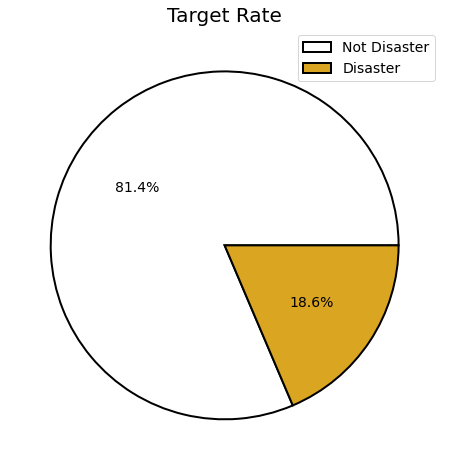

In [ ]:
fig = plt.figure(figsize=(10,8))

plt.pie(pd.Series(df['target']).value_counts(), autopct='%1.1f%%', 
        colors = ['white', 'goldenrod'],
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True},
        textprops = {"fontsize" :14})
plt.title('Target Rate', color='Black', fontsize=20)
plt.legend(['Not Disaster','Disaster'], fontsize=14)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Perbandingan Data Setiap Kelas')

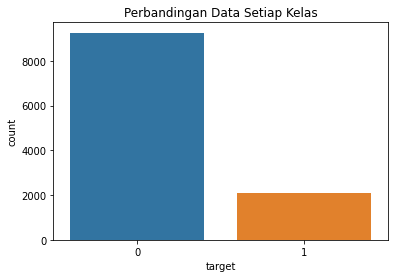

In [ ]:
sns.countplot('target', data=df)
plt.title('Perbandingan Data Setiap Kelas')

In [ ]:
df['target'].value_counts()

0    9256
1    2114
Name: target, dtype: int64

## Top 15 Keywords Overall

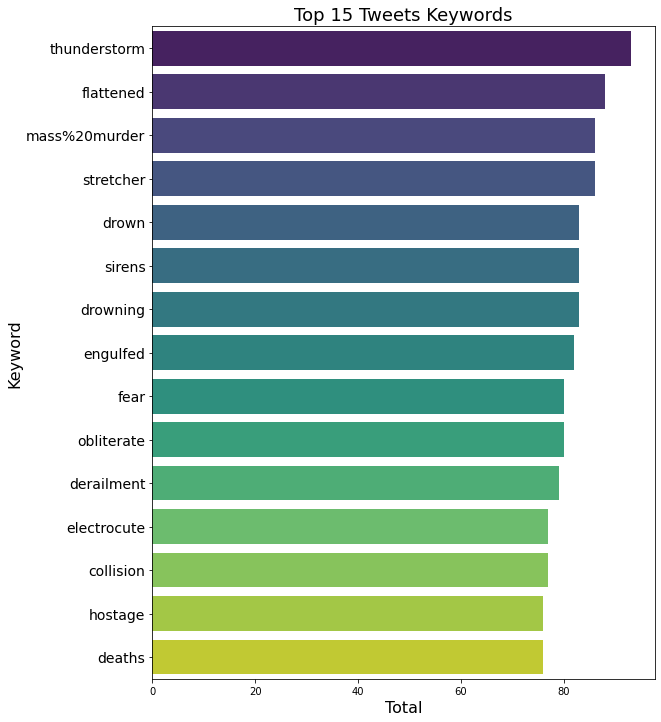

In [ ]:
plt.figure(figsize=(9,12))
sns.countplot(y=df.keyword, order = df.keyword.value_counts().iloc[:15].index, palette = 'viridis')

plt.title('Top 15 Tweets Keywords', fontsize=18)
plt.yticks(fontsize=14)
plt.ylabel('Keyword', fontsize= 16)
plt.xlabel('Total', fontsize= 16)
plt.show()

## Top 5 Disaster VS Non-Disaster

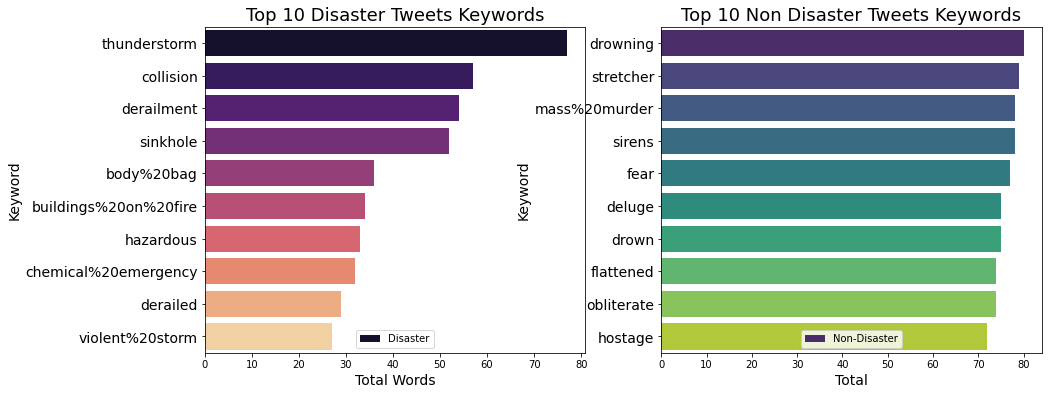

In [ ]:
plt.figure(figsize=(15,6))

#Disaster and Non-Disaster
yes = df[df['target']==1]
no = df[df['target']==0]

# Plot Disaster
plt.subplot(121)
sns.countplot(y=yes.keyword, 
              order = yes.keyword.value_counts().iloc[:10].index, 
              palette = 'magma', label= 'Disaster')

plt.title('Top 10 Disaster Tweets Keywords', fontsize=18)
plt.yticks(fontsize=14)
plt.ylabel('Keyword', fontsize= 14)
plt.xlabel('Total Words', fontsize= 14)
plt.legend(loc=8)

# Plot Non-Disaster
plt.subplot(122)
sns.countplot(y=no.keyword, 
              order = no.keyword.value_counts().iloc[:10].index, 
              palette = 'viridis', label= 'Non-Disaster')

plt.title('Top 10 Non Disaster Tweets Keywords', fontsize=18)
plt.yticks(fontsize=14)
plt.ylabel('Keyword', fontsize= 14)
plt.xlabel('Total', fontsize= 14)
plt.legend(loc = 8)


plt.show()

## Top Location

In [ ]:
loc = df.groupby('location').sum()['target'].sort_values(ascending=False).reset_index(name='disaster').head(20)

loc['percent'] = loc['disaster']*100/(df['target'].sum())

loc

,location,disaster,percent
0,UK,31,1.466414
1,Ireland,23,1.087985
2,United States,21,0.993377
3,"London, England",19,0.898770
4,Australia,15,0.709555
5,India,15,0.709555
6,"Atlanta, GA",14,0.662252
7,United Kingdom,13,0.614948
8,USA,10,0.473037
9,Republic of the Philippines,10,0.473037


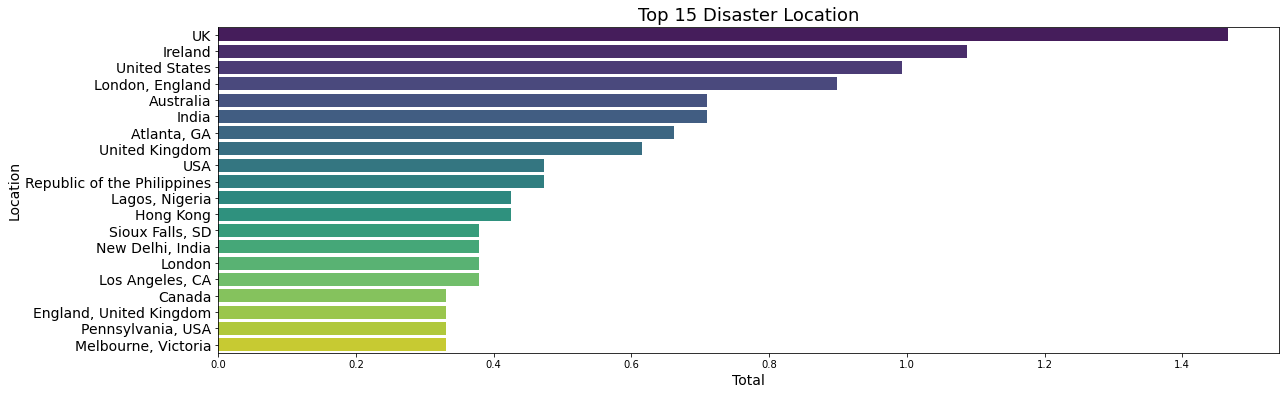

In [ ]:
plt.figure(figsize=(19,6))

sns.barplot(y='location', 
            x='percent', 
            data=loc,
            palette = 'viridis')

plt.title('Top 15 Disaster Location', fontsize=18)
plt.yticks(fontsize=14)
plt.ylabel('Location', fontsize= 14)
plt.xlabel('Total', fontsize= 14)
plt.show()



## Tweets Number in every Location visualize on Map

In [ ]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium 
from folium import plugins 


dft = df['location'].value_counts()[:20,]
dft = pd.DataFrame(dft)
dft = dft.reset_index()
dft.columns = ['location', 'counts'] 

geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

dictt_latitude = {}
dictt_longitude = {}
for i in dft['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
    
dft['latitude']= dft['location'].map(dictt_latitude)
dft['longitude'] = dft['location'].map(dictt_longitude)

United States
Australia
London, England
UK
India
London
United Kingdom
USA
California, USA
Los Angeles, CA
England, United Kingdom
Nigeria
Lagos, Nigeria
Melbourne, Victoria
Earth
Ireland
Canada
Mumbai, India
Nairobi, Kenya
South Africa


In [ ]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []


for i, row in dft.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#e2ff40', fill=True).add_to(map1)
map1

In [ ]:
dft.head()

,location,counts,latitude,longitude
0,United States,96,39.783730,-100.445882
1,Australia,83,-24.776109,134.755000
2,"London, England",81,51.507322,-0.127647
3,UK,77,54.702354,-3.276575
4,India,74,22.351115,78.667743
